# Logistic Regression Using Neural Networks

We'll build a logistic regression linear classifier to recognize *cats* from scratch.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

---
## **1- Packages** ##

First, let's import all the packages that we will need.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

---
## **2- Overview** ##

**Problem Statement**: You are given a dataset ("data.h5") containing:

- a training set of **m_train** images labeled as cat ($y=1$) or non-cat ($y=0$)
- a test set of **m_test** images labeled as cat or non-cat
- each image is of shape (**num_px**, **num_px**, 3) where 3 is for the 3 channels (RGB).
    - Thus, each image is square (height = num_px) and (width = num_px).

In [223]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = train_dataset["train_set_x"][:]  # train set features
    train_set_y_orig = train_dataset["train_set_y"][:]  # train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = test_dataset["test_set_x"][:] # test set features
    test_set_y_orig = test_dataset["test_set_y"][:] # test set labels

    classes = test_dataset["list_classes"][:]  # list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [224]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "**_orig**" at the end of image datasets (train and test) because we are going to pre-process them. After pre-processing, we will end up with **train_set_x** and **test_set_x** (the labels **train_set_y** and **test_set_y** don't need any pre-processing).

Each line of **train_set_x_orig** and **test_set_x_orig** is an array representing an image.

In [225]:
train_set_x_orig.shape, train_set_y.shape

((209, 64, 64, 3), (1, 209))

In [226]:
test_set_x_orig.shape, test_set_y.shape

((50, 64, 64, 3), (1, 50))

In [227]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

y=0, it's a 'non-cat'picture.


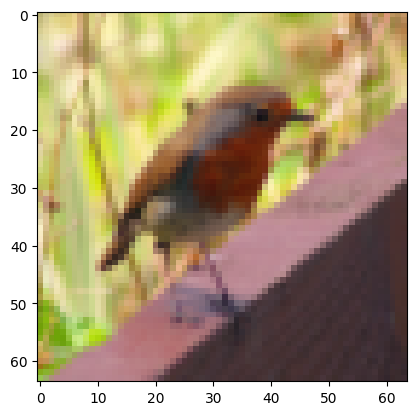

In [228]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print("y=" + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "'picture.")

In [229]:
# Let's get more familiar with the dataset
m_train = train_set_x_orig.shape[0]
m_test =  test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples:  m_test  = "   + str(m_test))
print ("Height/Width of each image:  num_px  = "   + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples:  m_test  = 50
Height/Width of each image:  num_px  = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, we should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image.

In [230]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))

print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common pre-processing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array.

But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [231]:
# Let's standardize our dataset
train_set_x = train_set_x_flatten / 255.
test_set_x  = test_set_x_flatten  / 255.

---
## **3- General Architecture of the learning algorithm** ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

We'll build a Logistic Regression, using a Neural Network. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**: we will carry out the following steps
- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyze the results and conclude

---
## **4- Building the parts of our algorithm** ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.


### **4.1- Activation function**

We first implement the `sigmoid()` activation function, defined as
$$\sigma(z) = \frac{1}{1 + e^{-z}}, \quad \text{ where  } z = w^T x + b$$

In [232]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### **4.2 - Initializing Parameters**

In [233]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    return w, b

### **4.3- Forward and Backward propagation**

Now that the parameters are initialized, we can do the "forward" and "backward" propagation steps for learning the parameters.

**Forward Propagation:**
- We get $\bm{X}$
- We compute $\bm{A} = \sigma(w^T \bm{X} + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- We calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m} \left[y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}) \right]$

Here're the two formulas we'll be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}\bm{X}(A - \bm{Y})^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [234]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)   # compute activation
    cost = np.sum(((-np.log(A)) * Y + (-np.log(1 - A)) * (1 - Y))) / m   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (np.dot(X, (A - Y).T)) / m
    db = (np.sum(A - Y)) / m

    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### **4.4- Optimization**
- Now, we want to update the parameters using gradient descent.

The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [235]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads dictionary
        dw = grads["dw"]
        db = grads["db"]
        
        # Update rule
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print (f"Cost after iteration {i}: {cost}")
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

The previous function will output the learned $w$ and $b$. We are able to use $w$ and $b$ to predict the labels for a dataset $\bm{X}$. We implement the `predict()` function.

**There are two steps to computing predictions:**
1. Calculate $\hat{\bm{Y}} = \bm{A} = \sigma(w^T \bm{X} + b)$
2. Convert the entries of $a$ into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`.

In [236]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b)  # Dimensions = (1, m)
    
    Y_prediction = (A >= 0.5) * 1.0
    
    return Y_prediction

## **5- Merge all functions into a model**
We will now put together all the building blocks (functions implemented in the previous parts), in the right order.

In [237]:
def LogisticRegression(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
     # initialize parameters with zeros
     w, b = initialize_with_zeros(X_train.shape[0])

     # Gradient descent
     parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

     # Retrieve parameters w and b from dictionary "parameters"
     w = parameters["w"]
     b = parameters["b"]

     # Predict test/train set examples
     Y_prediction_test  = predict(w, b, X_test)
     Y_prediction_train = predict(w, b, X_train)

     # Print train/test Errors
     print(f"train accuracy: {(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100):.2f}%")
     print(f"test accuracy:  {(100 - np.mean(np.abs(Y_prediction_test  - Y_test )) * 100):.2f}%")


     d = {
          "costs":  costs,
          "Y_prediction_test":  Y_prediction_test, 
          "Y_prediction_train":  Y_prediction_train, 
          "w":  w, 
          "b":  b,
          "learning_rate":  learning_rate,
          "num_iterations":  num_iterations
     }

     return d

In [238]:
# train our model
d = LogisticRegression(
    train_set_x,
    train_set_y,
    test_set_x,
    test_set_y,
    num_iterations = 2000,
    learning_rate = 0.005,
    print_cost = False
)

train accuracy: 91.39%
test accuracy:  34.00%


Note that the logistic regression is a linear classifier. Also, we can clearly see that the model is clearly overfitting the training data. We can reduce overfitting by using regularization, for example.

y=1, you predicted that it's a "non-cat" picture.


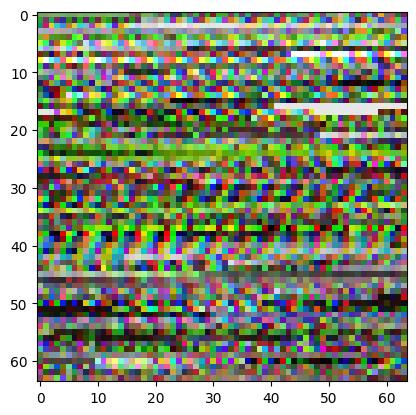

In [239]:
# Example of a picture that was wrongly classified
index = 25
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))

print ("y=" + str(test_set_y[0,index]) + ", you predicted that it's a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") + "\" picture.")

Let's also plot the cost function and the gradients.

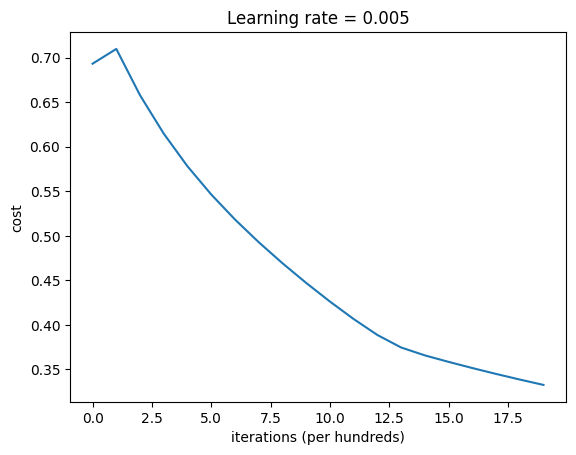

In [240]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()

**Interpretation**:
We can see the cost decreasing. It shows that the parameters are being learned. However, we could train the model even more on the training set by increasing the number of iterations. We might see that the training set accuracy goes up, but the test set accuracy goes down. This is called *overfitting*.

## Let's test with our own image

y=0.0, you predicted that it's a "non-cat" picture.


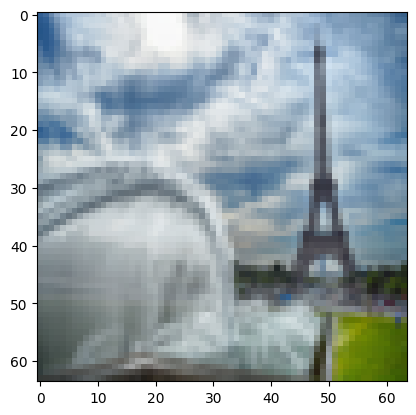

In [241]:
from scipy import ndimage
from PIL import Image

# We pre-process the image
my_image = "images/my_image.jpg"
image = Image.open(my_image)  # Open image using PIL
image = image.resize((num_px, num_px))  # Resize using PIL
image = np.array(image) / 255.0  # Convert to NumPy array and normalize

# Flatten and reshape
my_image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)  # Display the image

print("y=" + str(np.squeeze(my_predicted_image)) + ", you predicted that it's a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**References:**
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c